In [1]:
# !rm -rf /content/lgg-mri-segmentation.zip

In [2]:
! pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download "mateuszbuda/lgg-mri-segmentation"

 99% 710M/714M [00:08<00:00, 112MB/s]
100% 714M/714M [00:08<00:00, 85.5MB/s]


In [ ]:
! unzip lgg-mri-segmentation

In [8]:

 # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
!pip install monai

     |████████████████████████████████| 709 kB 32.2 MB/s 


In [10]:
from glob import glob
import matplotlib.pyplot as plt
import monai,torch
from torchvision import transforms
from monai.config import print_config
from monai.utils import first
from monai.config import KeysCollection
from monai.data import Dataset, ArrayDataset, create_test_image_3d, DataLoader
from monai.transforms import (
    Transform,
    AddChannel,
    AddChanneld,
    Compose,
    LoadImage,
    LoadImaged,
    Spacingd,
    Spacing,
    Resized,
    ScaleIntensityRanged,
    CropForegroundd,
    Resized,
    ToTensor,
    ToTensord,
    Orientation,
    Orientationd,
    NormalizeIntensityd,
    RandRotated,
    RandAxisFlipd,
    RandFlipd,
    
)
print_config()

MONAI version: 0.8.0
Numpy version: 1.19.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.7.0
gdown version: 4.2.1
TorchVision version: 0.11.1+cu111
tqdm version: 4.62.3
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [11]:
mask_files = sorted(glob('/content/kaggle_3m/*/*_mask*'))# /content/kaggle_3m

In [12]:
# Now we will store the path of all the corresponding input images files path to the mask files.
training_files = []
for path in mask_files:
    training_files.append(path.replace('_mask',''))

In [13]:
import skimage as sk


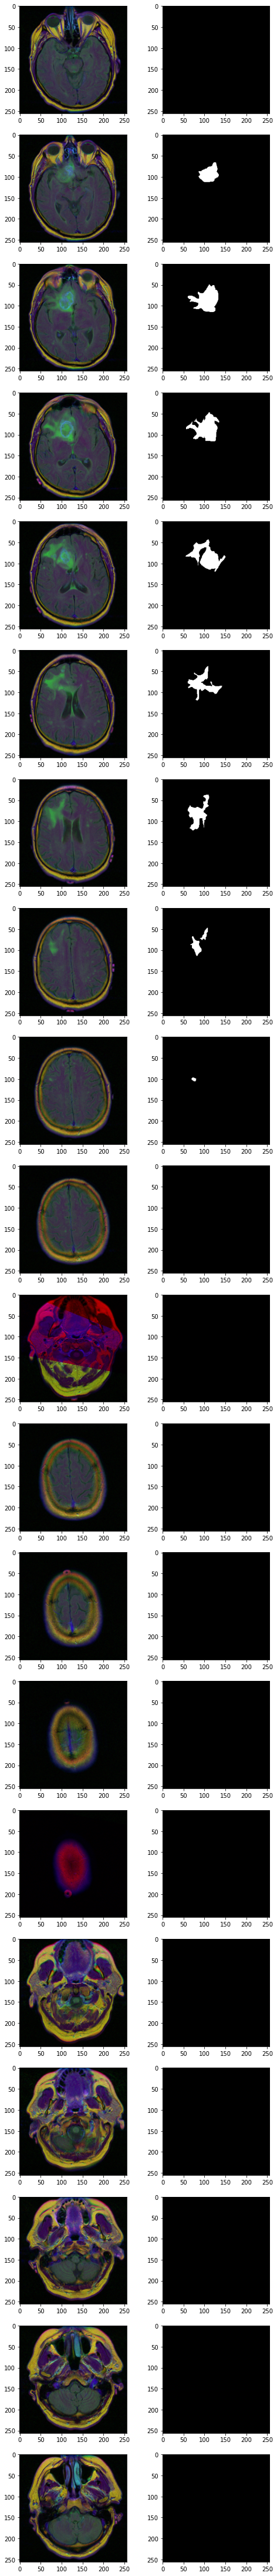

In [14]:
rows = 20
fig,ax = plt.subplots(rows,2,figsize=(8,80))
for i in range(rows):
    read1 = plt.imread(training_files[i])
    read2 = plt.imread(mask_files[i])
#print(np.max(read2))
    ax[i,0].imshow(read1)
    ax[i,1].imshow(read2,cmap='gray')
plt.show()

In some images there are masks while for few there are no masks

In [15]:
def is_mask(path):
    mask = plt.imread(path)
    if np.max(mask) != 0.0:
        return 1
    else:
        return 0

In [16]:
df = pd.DataFrame({'training_files':training_files,'mask_files':mask_files})
df['mask'] = df['mask_files'].apply(lambda x: is_mask(x))

In [17]:
df['mask_files']

0       /content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...
1       /content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...
2       /content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...
3       /content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...
4       /content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...
                              ...                        
3924    /content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...
3925    /content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...
3926    /content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...
3927    /content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...
3928    /content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...
Name: mask_files, Length: 3929, dtype: object

In [18]:
df.head()

training_files  ... mask
0  /content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...  ...    0
1  /content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...  ...    1
2  /content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...  ...    1
3  /content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...  ...    1
4  /content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...  ...    1

[5 rows x 3 columns]

In [19]:
df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [20]:
data = df[df['mask']==1]

In [21]:
data = data.drop(['mask'],axis=1)

In [22]:
data.head()

training_files                                         mask_files
1  /content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...  /content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...
2  /content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...  /content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...
3  /content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...  /content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...
4  /content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...  /content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...
5  /content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...  /content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


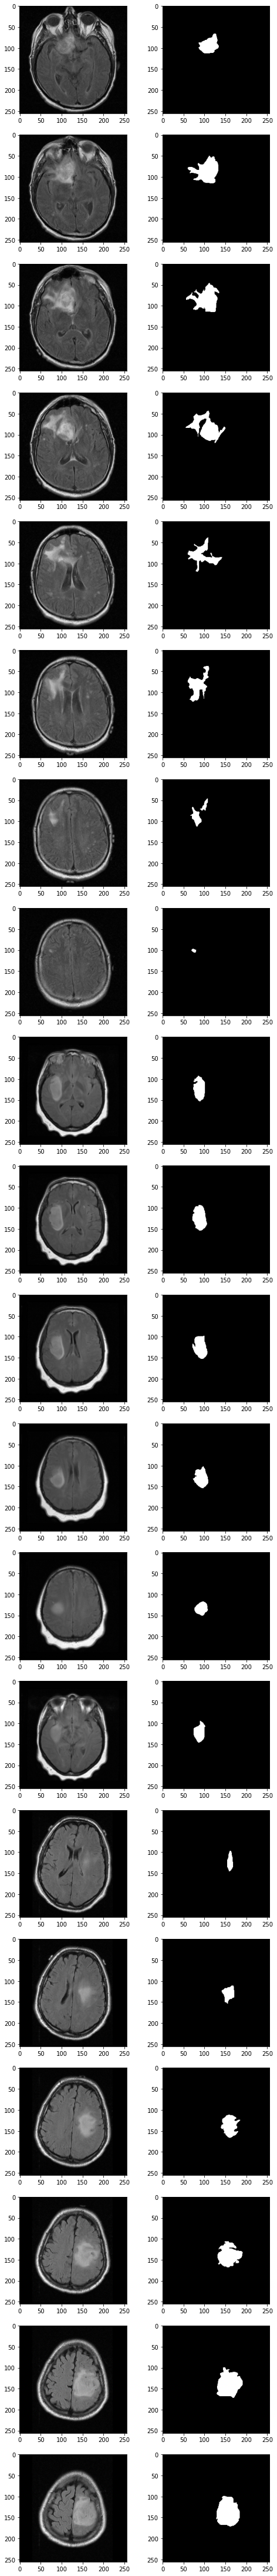

In [23]:
rows = 20
fig,ax = plt.subplots(rows,2,figsize=(8,80))
for i in range(rows):
    read1 = plt.imread(data['training_files'].iloc[i])
    read2 = plt.imread(data['mask_files'].iloc[i])
    im1 = sk.color.rgb2gray(read1)
    print(im1.shape)
    ax[i,0].imshow(im1,cmap='gray')
    ax[i,1].imshow(read2,cmap='gray')
plt.show()

In [24]:
!pip install imio

  Created wheel for configobj: filename=configobj-5.0.6-py3-none-any.whl size=34547 sha256=97c9e28a402ae76b49505ca5a8590f132e8516b647db125262ee1cdcc3bfebf1
  Stored in directory: /root/.cache/pip/wheels/0d/c4/19/13d74440f2a571841db6b6e0a273694327498884dafb9cf978
Successfully built configobj


# Dermining Preprocesseing Steps

In [25]:
from imio import load, save

In [26]:
dir = '/content/new_data'
mask_out_path = '/content/new_data/mask'
input_out_path = '/content/new_data/input'
os.mkdir(dir)
os.mkdir(mask_out_path)
os.mkdir(input_out_path)

In [27]:
training_files[0],data['training_files'].iloc[0]

('/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif',
 '/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif')

In [28]:
for path in data['training_files']:
    img = plt.imread(path)#load.load_any(path)
    img = sk.color.rgb2gray(img)
    #print(img.shape)
    name = os.path.basename(os.path.normpath(path))
    name = os.path.splitext(name)[0]
    save.to_nii(img, "{}/{}.nii.gz".format(input_out_path,name))
  

In [29]:
for path in data['mask_files']:
    img = plt.imread(path)
    img = sk.color.rgb2gray(img)
    name = os.path.basename(os.path.normpath(path))
    name = os.path.splitext(name)[0]
    save.to_nii(img, "{}/{}.nii.gz".format(mask_out_path,name))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
filenames = []
img = sorted(glob('/content/new_data/input/*'))
mask = sorted(glob('/content/new_data/mask/*'))
print('len : ',len(img),len(mask))
for i in range(len(img)):
    filenames.append({'img':img[i],'mask':mask[i]})

len :  1373 1373


## Scalling the intensities

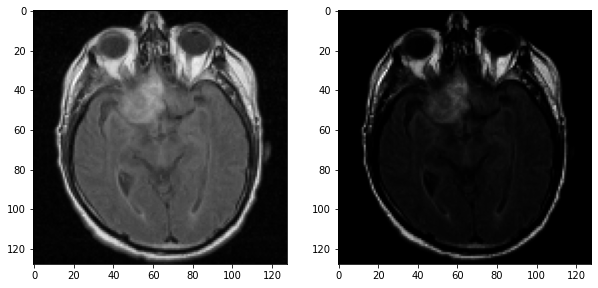

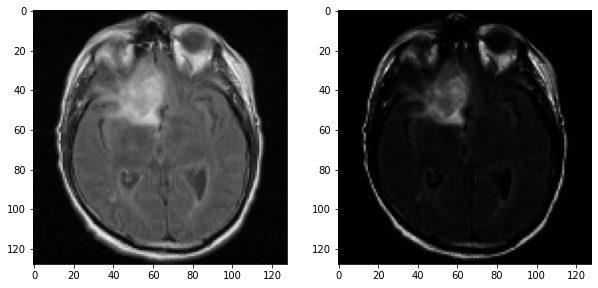

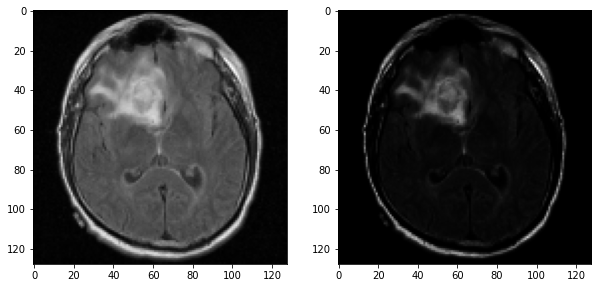

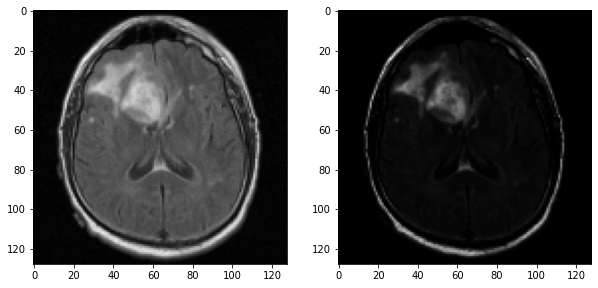

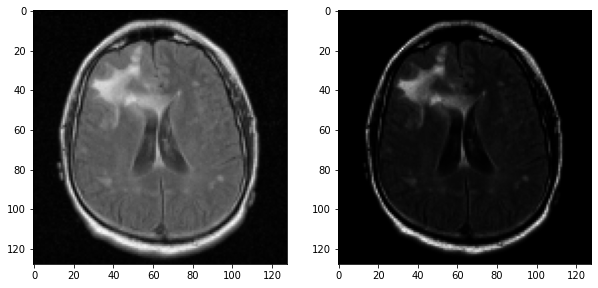

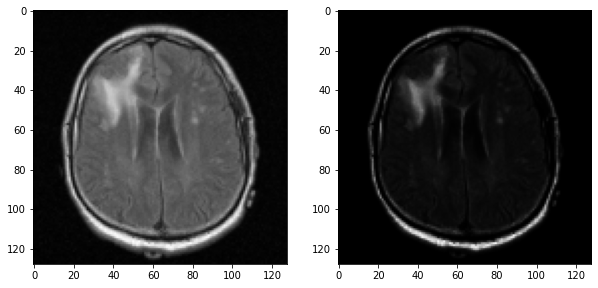

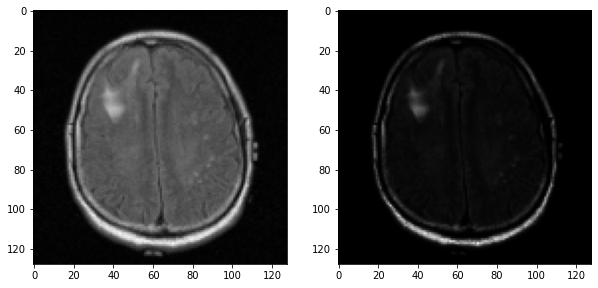

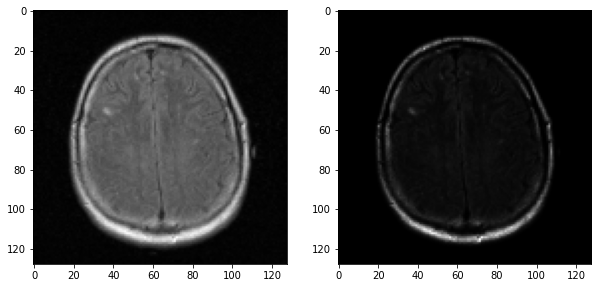

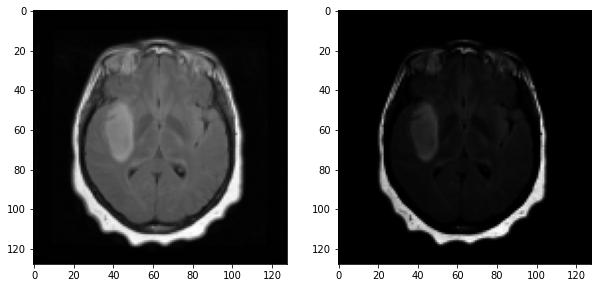

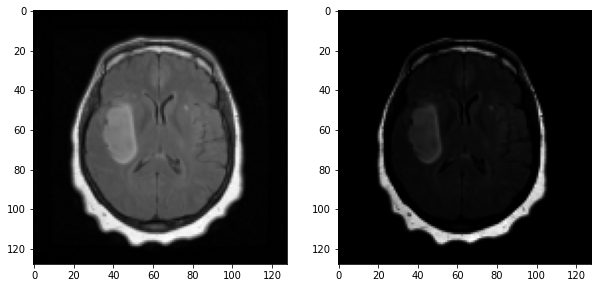

In [31]:
from monai.transforms.intensity.dictionary import AdjustContrastd
for i in range(0,10):
  li = LoadImaged(keys=['img','mask'])
  li_img = li(filenames[i])
  li_img['img'].shape
  add = AddChanneld(keys=['img','mask'])
  add_img = add(li_img)
  res = Resized(spatial_size  = (128,128),keys=['img'])
  res_img = res(add_img)
  res_img['img'].shape
  si = AdjustContrastd(keys=["img"],gamma=3)
  si_img = si(res_img)
  #print('>> ',np.max(si_img['img']))
  fig,ax = plt.subplots(1,2,figsize=(10,5))
  ax[0].imshow(res_img['img'][0,:,:],cmap='gray')
  ax[1].imshow(si_img['img'][0,:,:],cmap='gray')
  #np.max(si_img['img']),np.max(si_img['mask']),si_img['img'].shape

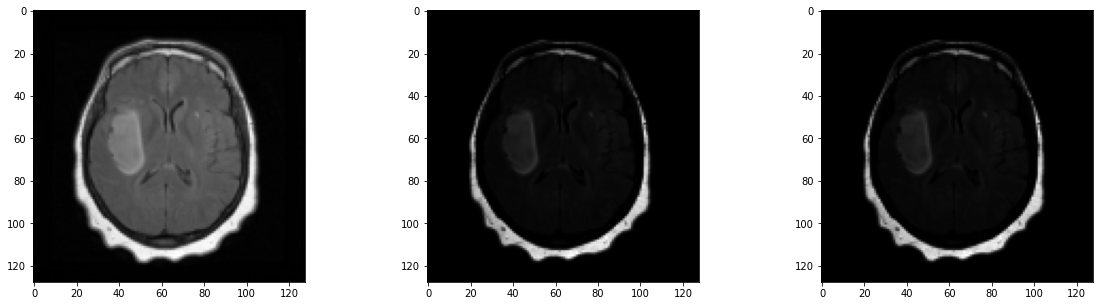

In [32]:
norm = NormalizeIntensityd(keys=['img','mask'],divisor=255.0,subtrahend=0)
norm_img = norm(si_img)
fig,ax = plt.subplots(1,3,figsize=(20,5))
ax[0].imshow(res_img['img'][0,:,:],cmap='gray')
ax[1].imshow(si_img['img'][0,:,:],cmap='gray')
ax[2].imshow(norm_img['img'][0,:,:],cmap='gray')

In [33]:
np.max(norm_img['img']),np.max(norm_img['mask'])

(0.0030941146, 1.0)

In [51]:
org_img = Compose([
    LoadImaged(keys=['img','mask']),
    AddChanneld(keys=['img','mask']),
    Resized(spatial_size  = (128,128),keys=['img','mask']),
    #Resized(spatial_size  = (128,128),keys=['mask']),
    AdjustContrastd(keys="img",gamma=2),
    # RandRotated(keys=['key','mask'],range_x=[0.4,0.4],prob=0.1),
    # RandAxisFlipd(keys=['key','mask'],prob=0.1),
    # RandFlipd(keys=['key','mask'],prob=0.1),
    NormalizeIntensityd(keys=['img','mask'],divisor=255.0,subtrahend=0),
    ToTensor(),
])
preprocess = Compose([
    LoadImaged(keys=['img','mask']),
    AddChanneld(keys=['img','mask']),
    # RandRotated(keys=['key','mask'],range_x=[0.4,0.4],prob=0.1,),
    # RandAxisFlipd(keys=['key','mask'],prob=0.1,),
    # RandFlipd(keys=['key','mask'],prob=0.1,),
    Resized(spatial_size  = (128,128),keys=['img','mask']),
    #Resized(spatial_size  = (128,128),keys=['mask']),
    
    
    AdjustContrastd(keys="img",gamma=2),
    NormalizeIntensityd(keys=['img','mask'],divisor=255.0,subtrahend=0),
    ToTensor(),
])


In [52]:
train_data = Dataset(data = filenames,transform = preprocess)

In [53]:
from torch.utils.data import random_split
val = int((len(train_data)/100)*30) # 20%
org = len(train_data)-val
print(val,org)
train_ds,val_ds = random_split(train_data,[org,val])

411 962


In [54]:
train_loder = DataLoader(train_ds,batch_size = 1)
val_loder = DataLoader(val_ds,batch_size = 1)

In [55]:
train_patient = first(train_loder)
val_patient = first(val_loder)

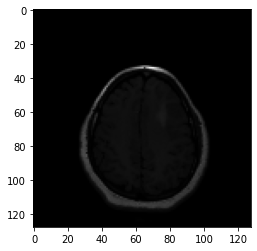

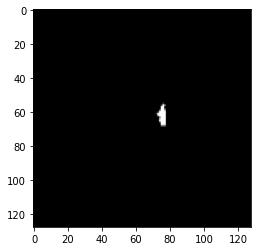

In [56]:
train_patient['img'].shape
plt.imshow(train_patient['img'][0,0,:,:],cmap='gray')
plt.show()
plt.imshow(train_patient['mask'][0,0,:,:],cmap='gray')

0.0016461965 (1, 1, 128, 128) (1, 1, 128, 128)
0.0016461965 (1, 1, 128, 128) (1, 1, 128, 128)
0.0029663914 (1, 1, 128, 128) (1, 1, 128, 128)
0.0028841505 (1, 1, 128, 128) (1, 1, 128, 128)
0.0027027945 (1, 1, 128, 128) (1, 1, 128, 128)


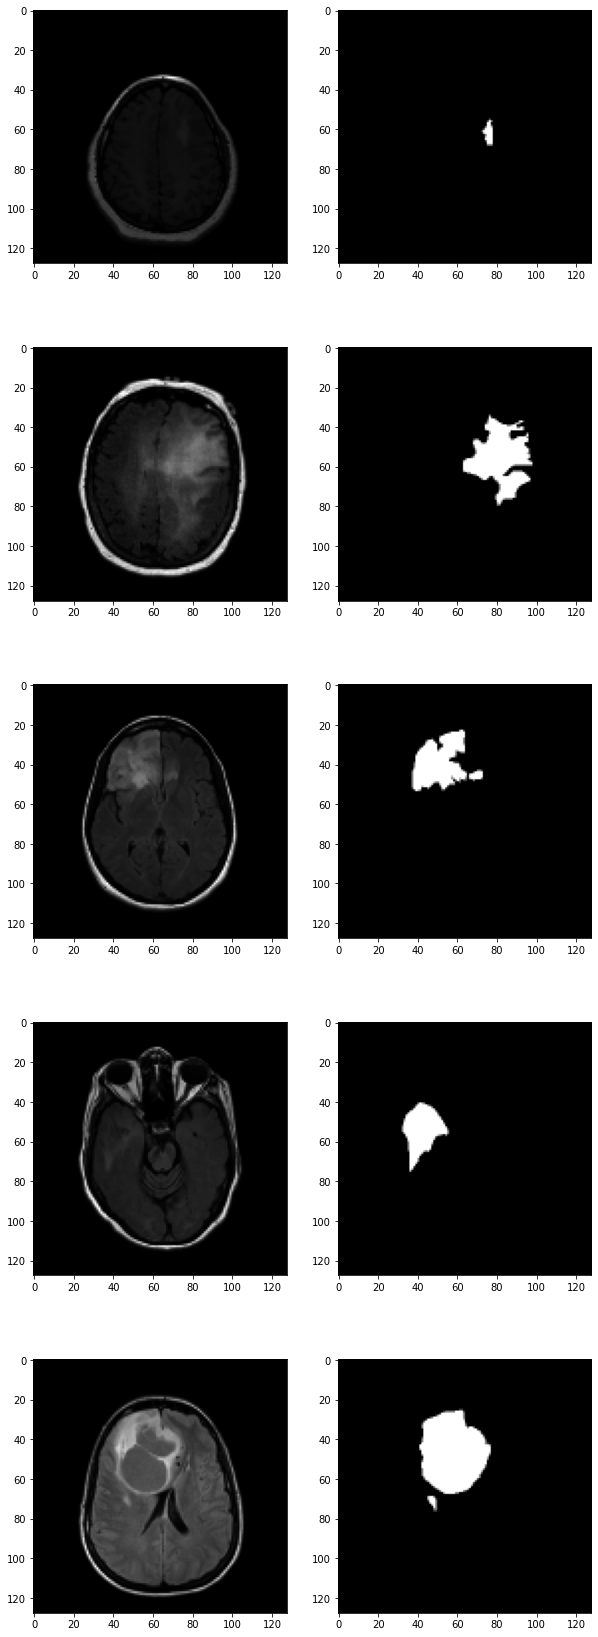

In [57]:
r = 5
fig,ax = plt.subplots(r,2,figsize=(10,30))
rr = 0
for batc in train_loder:
  print(np.max(train_patient['img'][0,0,:,:].numpy()),train_patient['img'].numpy().shape,train_patient['mask'].numpy().shape)
  train_patient = batc
  ax[rr][0].imshow(train_patient['img'][0,0,:,:],cmap='gray')
  ax[rr][1].imshow(train_patient['mask'][0,0,:,:],cmap='gray')

  if rr >=4:
    break
  rr+=1

In [59]:
import torch, torchvision 
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F

In [60]:
device='cuda'
torch.cuda.empty_cache()

In [61]:
model = monai.networks.nets.UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64,128,256,512),
        dropout=0.3,
        strides=(2, 2, 2, 2,2),
        num_res_units=3,
    
    ).to(device)
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [62]:
epoch_loss_values = []
val_loss_values = []

In [72]:
num_epochs = 10
from tqdm import tqdm

In [75]:
for epoch in (range(num_epochs)):
        print("-" * num_epochs)
        print(f"epoch {epoch + 1}/{num_epochs}")
        model.train()
        epoch_loss = 0
        avg_val_loss = 0
        step = 0
        print('traning')
        for batch_data in tqdm(train_loder):
            step += 1
            inputs, labels = torch.reshape(batch_data['img'],(1,1,128,128)).to(device), batch_data['mask'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loder.batch_size
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        
        
        ii = 0
        
        for batch in tqdm(val_loder):#val_patient
            ii+=1
            inputs, labels = torch.reshape(batch['img'],(1,1,128,128)).to(device), batch['mask'].to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            avg_val_loss+=loss.item()
        avg_val_loss = avg_val_loss/ii
        val_loss_values.append(avg_val_loss)
       
        
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f} validation_loss: {avg_val_loss:.4f}")

----------
epoch 1/10
traning


100%|██████████| 411/411 [00:06<00:00, 60.47it/s]


epoch 1 average loss: 0.2516 validation_loss: 0.2781
----------
epoch 2/10
traning


100%|██████████| 411/411 [00:06<00:00, 60.21it/s]


epoch 2 average loss: 0.2556 validation_loss: 0.2655
----------
epoch 3/10
traning


100%|██████████| 411/411 [00:06<00:00, 60.66it/s]


epoch 3 average loss: 0.2490 validation_loss: 0.2588
----------
epoch 4/10
traning


100%|██████████| 411/411 [00:06<00:00, 59.70it/s]


epoch 4 average loss: 0.2430 validation_loss: 0.2572
----------
epoch 5/10
traning


100%|██████████| 411/411 [00:06<00:00, 59.97it/s]


epoch 5 average loss: 0.2477 validation_loss: 0.2621
----------
epoch 6/10
traning


100%|██████████| 411/411 [00:06<00:00, 60.27it/s]


epoch 6 average loss: 0.2511 validation_loss: 0.2685
----------
epoch 7/10
traning


100%|██████████| 411/411 [00:06<00:00, 60.50it/s]


epoch 7 average loss: 0.2405 validation_loss: 0.2564
----------
epoch 8/10
traning


100%|██████████| 411/411 [00:06<00:00, 59.82it/s]


epoch 8 average loss: 0.2499 validation_loss: 0.2564
----------
epoch 9/10
traning


100%|██████████| 411/411 [00:06<00:00, 60.70it/s]


epoch 9 average loss: 0.2527 validation_loss: 0.2737
----------
epoch 10/10
traning


100%|██████████| 411/411 [00:06<00:00, 60.57it/s]

epoch 10 average loss: 0.2498 validation_loss: 0.2656


In [81]:
torch.save(model,'model_gray_3')

In [82]:
!zip '/content/mod3.zip' "/content/model_gray_3" 

  adding: content/model_gray_3 (deflated 7%)


<class 'list'> <class 'float'> 60


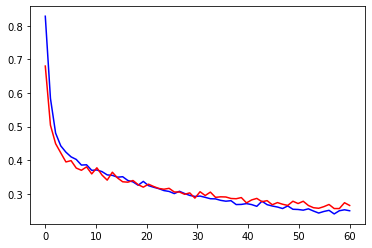

In [76]:
print(type(val_loss_values),type(val_loss_values[0]),len(val_loss_values))
#val_loss_values = [e.detach().numpy() for e in val_loss_values]
plt.plot(np.linspace(0,len(epoch_loss_values),len(epoch_loss_values)),epoch_loss_values,color='blue')
plt.plot(np.linspace(0,len(val_loss_values),len(val_loss_values)),val_loss_values,color='red')

<class 'list'> <class 'float'> 45


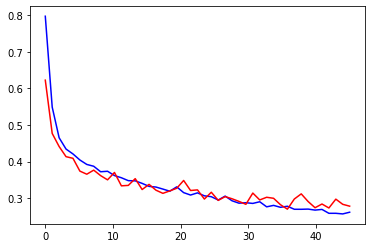

In [142]:
print(type(val_loss_values),type(val_loss_values[0]),len(val_loss_values))
#val_loss_values = [e.detach().numpy() for e in val_loss_values]
plt.plot(np.linspace(0,len(epoch_loss_values),len(epoch_loss_values)),epoch_loss_values,color='blue')
plt.plot(np.linspace(0,len(val_loss_values),len(val_loss_values)),val_loss_values,color='red')

torch.Size([1, 1, 128, 128]) float32
torch.Size([1, 1, 128, 128]) float32
torch.Size([1, 1, 128, 128]) float32
torch.Size([1, 1, 128, 128]) float32
torch.Size([1, 1, 128, 128]) float32
torch.Size([1, 1, 128, 128]) float32
torch.Size([1, 1, 128, 128]) float32
torch.Size([1, 1, 128, 128]) float32
torch.Size([1, 1, 128, 128]) float32
torch.Size([1, 1, 128, 128]) float32
torch.Size([1, 1, 128, 128]) float32
torch.Size([1, 1, 128, 128]) float32
torch.Size([1, 1, 128, 128]) float32
torch.Size([1, 1, 128, 128]) float32
torch.Size([1, 1, 128, 128]) float32
torch.Size([1, 1, 128, 128]) float32
torch.Size([1, 1, 128, 128]) float32
torch.Size([1, 1, 128, 128]) float32
torch.Size([1, 1, 128, 128]) float32
torch.Size([1, 1, 128, 128]) float32


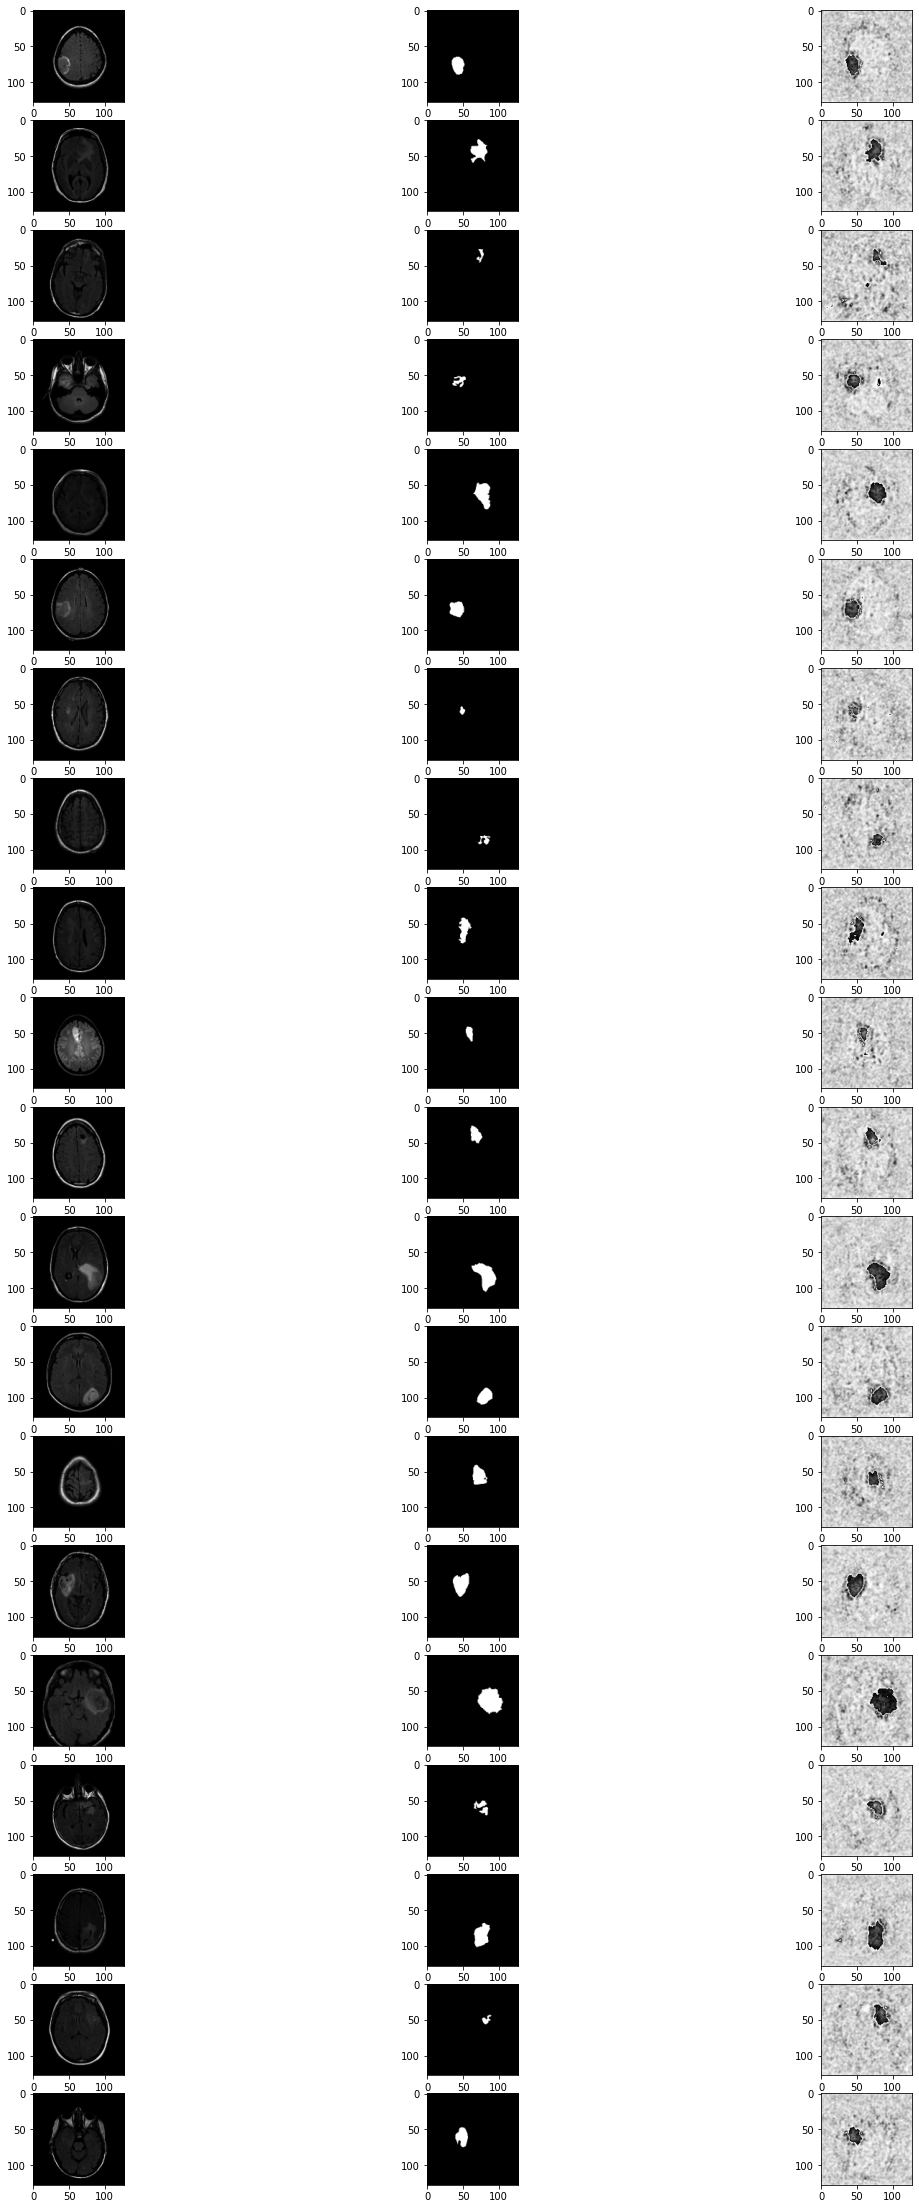

In [83]:
r = 20
i=0
fig,ax = plt.subplots(r,3,figsize=(20,40))
for batch in val_loder:
  inp = torch.reshape(batch['img'],(1,1,128,128)).to(device)
  out = model(inp).to('cpu')
  print(out.shape,(out[0,0,:,:].detach().numpy().dtype))
  ax[i,0].imshow(batch['img'][0,0,:,:],cmap='gray')
  ax[i,1].imshow(batch['mask'][0,0,:,:],cmap='gray')
  ax[i,2].imshow(out[0,0,:,:].detach().numpy().astype('uint8'),cmap='gray')
  
  if i>=r-1:
    break
  i=i+1


In [110]:
out2 = out.to('cpu')

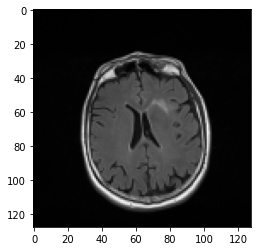

In [114]:
plt.imshow(val_patient['img'][0,0,:,:],cmap='gray')

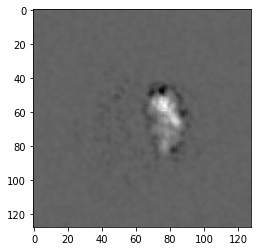

In [116]:
plt.imshow(out2[0,0,:,:].detach().numpy(),cmap='gray')

In [113]:
np.max(val_patient['mask'][0,0,:,:].numpy()),np.max(out2[0,0,:,:].detach().numpy())

(1.0, 369.06662)

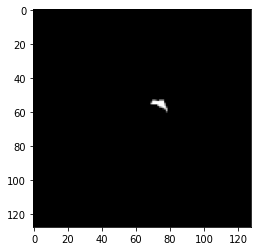

In [115]:
plt.imshow(val_patient['mask'][0,0,:,:],cmap='gray')

In [ ]:
|
"""
Initialize the network and the Adam optimizer
"""
device='cuda'
net = Unet().to(device)

Loss1 = []
Val_loss = []


SyntaxError: ignored

In [ ]:
learning_rate = 0.001
num_epochs = 1
from monai.losses.dice import DiceLoss
dl = DiceLoss(sigmoid=True)
from tqdm import tqdm

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
ii = 0
losss = []
iter1 = []
val_loss = []
#dl = DiceLoss()
for epoch in range(num_epochs):
    
    
    for batch in (train_loder):
        #print("###################################\n")
        img = torch.reshape(batch['img'],(1,3,256,256)).to(device)
        mask = batch['mask'].to(device)
        
        #print('shap : ',torch.max(output),torch.max(mask),'Output\n ',output,'Mask\n',mask)
        
        optimizer.zero_grad()
        output = net(img)
        loss = dl(output,mask)
        loss.backward()
        losss.append(loss.cpu())
        optimizer.step()
        #print('Output is : ',loss)
        
        iter1.append(ii)
        
        if ii>=300:
            print('Output is : ',loss)
        ii = ii+1
        #break
    print('Output is : ',loss)
    #break
        
        

In [ ]:
print(type(iter1[0]),type(losss[0]))
losss = [el.detach().numpy() for el in losss]
plt.plot(iter1,losss)